In [109]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.optimize

In [110]:
class Generate_random_fx_and_train_points:
    def __init__(self,range_from,range_to,N):
        self.range_from = range_from
        self.range_to = range_to
        self.N = N
        self.randomize_fx()
        self.randomize_data()
        
    def randomize_fx(self):
        X = np.random.uniform(self.range_from,self.range_to,2)
        Y = np.random.uniform(self.range_from,self.range_to,2)
        
        fit = np.polyfit(X,Y,1)
        self.target = np.poly1d(fit)
    
    def randomize_data(self):
        plus = False
        minus = False
        while(plus == False or minus == False):
            plus = False
            minus = False
            self.X = np.random.uniform(self.range_from,self.range_to,(self.N,2))
            self.Y = []
            for x in self.X:
                y = self.fx(x[0],x[1])
                if(y==1):
                    plus = True
                elif(y==-1):
                    minus = True
                self.Y.append(y)
        self.X = np.hstack((np.ones((len(self.X),1)),self.X))
        self.X = [np.array(i,ndmin=2).T for i in self.X]
        self.Y = np.reshape(self.Y,(self.N,1))
   
    def fx(self,x, y):
        original_y = self.target(x)
        return 1 if original_y < y else -1      

In [111]:
class PLA:
    def __init__(self,fx,X,Y,test_size):
        self.fx = fx
        self.X = X
        self.Y = Y
        self.test_size = test_size
        self.w = np.zeros((3,1))
        self.train()
        self.test_e_out()
        
    def train(self):
        while(True):
            all_correct = True
            
            low = 0
            high = len(self.X)

            while(low<high):
                idx = np.random.randint(low,high)
                answer = np.sign(np.dot(self.w.T,self.X[idx]))
                if(answer != self.Y[idx]):
                    all_correct = False
                    self.w+=self.Y[idx]*self.X[idx]
                else:
                    self.X[low], self.X[idx] = self.X[idx], self.X[low]
                    self.Y[[low,idx]]=self.Y[[idx,low]]
                    low+=1
            
            if(all_correct):
                break
    
    def test_e_out(self):
        X_test = np.random.uniform(-1,1,(self.test_size, 2))
        X_test = np.hstack((np.ones((len(X_test),1)), X_test))
        X_test = [np.array(i,ndmin=2).T for i in X_test]
        Y_test = [self.target(i[1],i[2]) for i in X_test]
        Y_test = np.reshape(Y_test,(len(Y_test),1))

        errors=0
        for i in range(len(X_test)):
            answer = np.sign(np.dot(self.w.T,X_test[i]))
            if(answer!=Y_test[i]):
                errors+=1
        self.e_out = errors / self.test_size
        
        
    def target(self,x,y):
        original_y = self.fx(x)
        return 1 if original_y < y else -1

In [112]:
class Plot_everything:
    def __init__(self,target,X,Y,pla_w,svm_w,svm_alphas):
        self.target = target
        self.pla_w = pla_w
        self.svm_w = svm_w
        self.svm_alphas = svm_alphas
        self.X = X
        self.Y = Y
        self.xs = x = np.linspace(-1,1,100)
        
        self.plot_target()
        self.plot_points()
        self.plot_pla()
        
        self.plot_svm()
        self.highlight_support_vectors()
        
        plt.legend()
        plt.axis([-1,1,-1,1])
        plt.show()
        
    def plot_target(self):
        plt.plot(self.xs,[self.target(i) for i in self.xs],label='Target')
    
    def plot_points(self):
        for i in range(len(self.X)):
            if(self.Y[i]==1):
                plt.plot(self.X[i][1],self.X[i][2],'g.')
            elif(a.Y[i]==-1):
                plt.plot(self.X[i][1],self.X[i][2],'r.')
                
    def plot_pla(self):
        plt.plot(self.xs,[-self.pla_w[0]/self.pla_w[2] - self.pla_w[1]/self.pla_w[2]*i for i in self.xs],label='PLA')
        
    def plot_svm(self):
        plt.plot(self.xs,[-self.svm_w[0]/self.svm_w[2]-self.svm_w[1]/self.svm_w[2]*i for i in self.xs],label='SVM')
    
    def highlight_support_vectors(self):
        for i in range(len(self.svm_alphas)):
            if(self.svm_alphas[i]!=0):
                if(self.Y[i]==1):
                    plt.plot(self.X[i][1],self.X[i][2],color='#003300',marker='^')
                elif(a.Y[i]==-1):
                    plt.plot(self.X[i][1],self.X[i][2],color='#800000',marker='^')

In [113]:
# Solves quadratic programming problem of type
# minimize 1/2 * x.T * G * x + a.T * x
# subject to C * x >= b
# Pass G - NxN; a - 1xN; C - MxN; b - 1xM
# return - 1xN
def solve_qp(G, a, C, b):
    x0 = np.random.randn(len(G))

    def loss(x, sign=1.):
        return sign * (0.5 * np.dot(x.T, np.dot(G,x)) + np.dot(a, x))

    def jac(x, sign=1.):
        return sign * (np.dot(x.T,G) + a)

    cons = {'type':'ineq',
           'fun':lambda x: np.dot(C,x) - b,
           'jac':lambda x: C}

    opt = {'disp':False}

    return scipy.optimize.minimize(loss, x0, jac=jac, constraints=cons, method='SLSQP',options=opt).x

In [114]:
class Hard_margin_svm:
    def __init__(self,fx,X,Y, test_size):
        self.fx = fx
        self.X = X
        self.Y = Y
        self.test_size = test_size
        
        self.construct_g()
        self.a = np.ones((len(self.Y)))
        self.construct_c()
        self.b = np.zeros(len(self.X)+2)
        
        self.alphas = np.around(solve_qp(self.g, -self.a, self.c, self.b),5)
        
        self.calculate_w()
        self.calculate_b()
        
        self.test_e_out()
        
    def calculate_w(self):
        self.w = np.zeros((len(self.X[0]),1))
        self.support_vectors_num = 0
        for i in range(len(self.X)):
            if(self.alphas[i]!=0):
                self.w += self.Y[i]*self.alphas[i]*self.X[i]
                self.support_vectors_num+=1
    
    def calculate_b(self):
        self.b = 0
        first = True
        y_s_idx = -1
        for i in range((len(self.X))):
            if(self.alphas[i]!=0):
                if(first):
                    first=False
                    y_s_idx = i
            self.b+= self.Y[i]*self.alphas[i]*np.dot(self.X[i].T,self.X[y_s_idx])
        self.b = self.Y[y_s_idx] - self.b
        self.w[0][0]=self.b
    
    def test_e_out(self):
        X_test = np.random.uniform(-1,1,(self.test_size, 2))
        X_test = np.hstack((np.ones((len(X_test),1)), X_test))
        X_test = [np.array(i,ndmin=2).T for i in X_test]
        Y_test = [self.target(i[1],i[2]) for i in X_test]
        Y_test = np.reshape(Y_test,(len(Y_test),1))

        errors=0
        for i in range(len(X_test)):
            answer = np.sign(np.dot(self.w.T,X_test[i]))
            if(answer!=Y_test[i]):
                errors+=1
        self.e_out = errors / self.test_size
        
        
    def target(self,x,y):
        original_y = self.fx(x)
        return 1 if original_y < y else -1
    
    def construct_g(self):
        self.g = []
        for i in range(len(self.X)):
            row = []
            for j in range(len(self.X)):
                row.append((self.Y[i] * self.Y[j] * np.dot(self.X[i].T , self.X[j])).tolist()[0])
            self.g.append(row)
        self.g = np.reshape(self.g,(len(self.X),len(self.X)))
        self.g = np.array(self.g)
        
    def construct_c(self):      
        self.c = self.Y.T.tolist()
        self.c.append(np.negative(self.Y.T).tolist()[0])
        self.c = np.reshape(self.c,(2,len(self.Y)))
        self.c = np.concatenate((self.c, np.identity(len(self.X))))

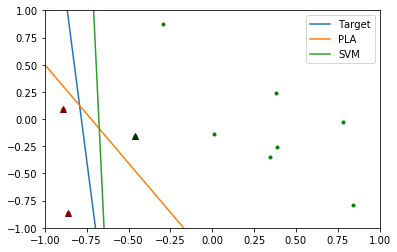

In [115]:
test_size = 300
N = 10
a = Generate_random_fx_and_train_points(-1,1,N)
pla = PLA(a.target,a.X,a.Y,test_size)
svm = Hard_margin_svm(a.target,a.X,a.Y,test_size)
p = Plot_everything(a.target,a.X,a.Y,pla.w,svm.w,svm.alphas)

In [43]:
# task 8
N = 10
test_size = 300
runs = 1000

n_svm_e_out_better = 0
for i in range(runs):
    a = Generate_random_fx_and_train_points(-1,1,N)
    pla = PLA(a.target,a.X,a.Y,test_size)
    svm = Hard_margin_svm(a.target,a.X,a.Y,test_size)
    
    if(pla.e_out > svm.e_out):
        n_svm_e_out_better+=1
print('SVM E_out was better ', n_svm_e_out_better/runs * 100,'% times')

SVM E_out was better  59.0 % times


In [116]:
# task 9 and 10
N = 100
test_size = 1000
runs = 1000

n_svm_e_out_better = 0
n_support_vectors = 0
for i in range(runs):
    a = Generate_random_fx_and_train_points(-1,1,N)
    pla = PLA(a.target,a.X,a.Y,test_size)
    svm = Hard_margin_svm(a.target,a.X,a.Y,test_size)
    
    n_support_vectors += svm.support_vectors_num
    if(pla.e_out > svm.e_out):
        n_svm_e_out_better+=1
print('SVM E_out was better ', n_svm_e_out_better/runs * 100,'% times')
print('Average number of support vectors is: ',n_support_vectors/runs)

SVM E_out was better  59.5 % times
Average number of support vectors is:  2.996
